In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = '/content/DB/train'
classes = os.listdir(path)
classes =['BEN', 'CAN','NOR']

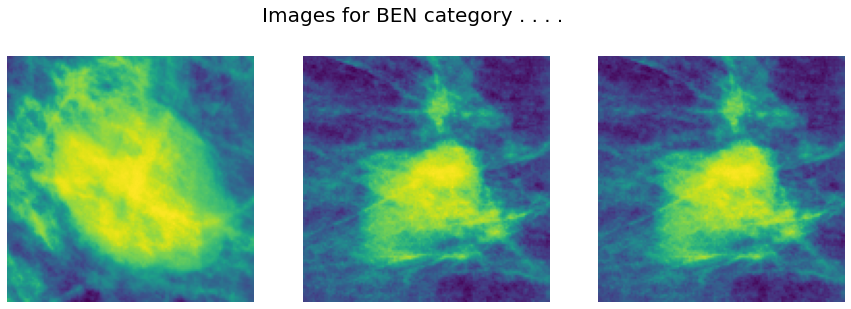

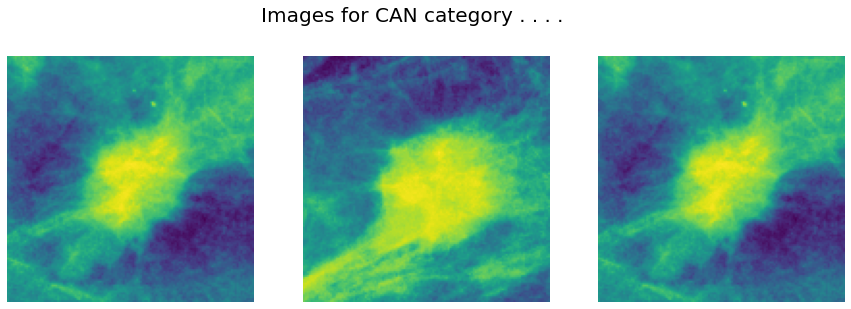

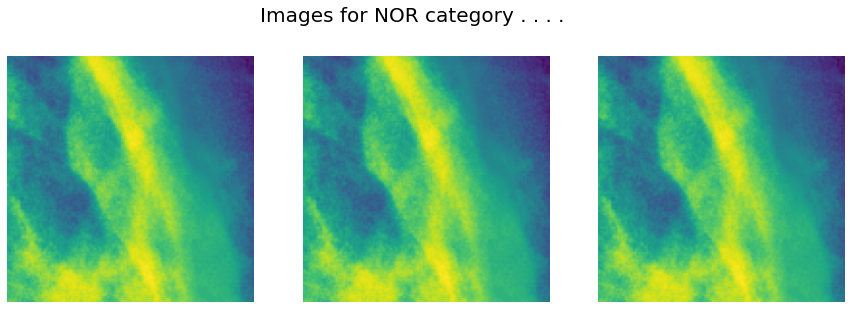

In [ ]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [ ]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [ ]:
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.*')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values
X

array([[[[102, 102, 102],
         [102, 102, 102],
         [103, 103, 103],
         ...,
         [109, 109, 109],
         [110, 110, 110],
         [110, 110, 110]],

        [[103, 103, 103],
         [103, 103, 103],
         [104, 104, 104],
         ...,
         [110, 110, 110],
         [110, 110, 110],
         [110, 110, 110]],

        [[104, 104, 104],
         [105, 105, 105],
         [107, 107, 107],
         ...,
         [111, 111, 111],
         [110, 110, 110],
         [110, 110, 110]],

        ...,

        [[116, 116, 116],
         [116, 116, 116],
         [119, 119, 119],
         ...,
         [113, 113, 113],
         [115, 115, 115],
         [117, 117, 117]],

        [[119, 119, 119],
         [119, 119, 119],
         [121, 121, 121],
         ...,
         [113, 113, 113],
         [115, 115, 115],
         [116, 116, 116]],

        [[120, 120, 120],
         [121, 121, 121],
         [122, 122, 122],
         ...,
         [113, 113, 113],
        

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, 
                                                  one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(4, 256, 256, 3) (2, 256, 256, 3)


In [ ]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),
 
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 128)     

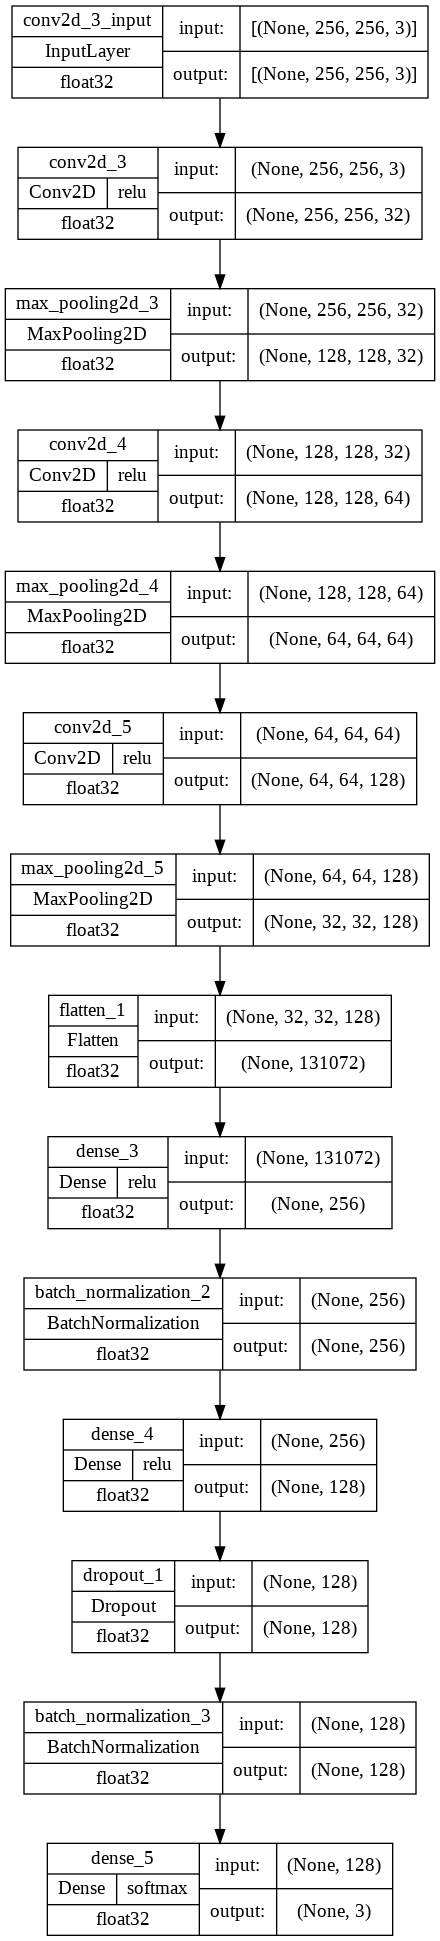

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
 
 
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)
 
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
history = model.fit(X_train, 
                    Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

(4, 256, 256, 3)
(4, 3)
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 1.0737 - accuracy: 0.5000 - val_loss: 30.3609 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.4949 - accuracy: 0.7500 - val_loss: 21.6142 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.3278 - accuracy: 1.0000 - val_loss: 18.9683 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.6692 - accuracy: 0.7500 - val_loss: 16.9936 - val_accuracy: 0.5000 - lr: 5.0000e-04


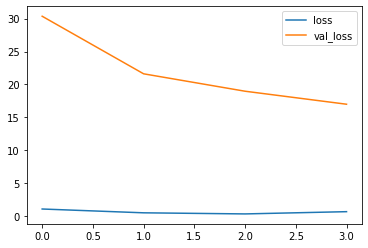

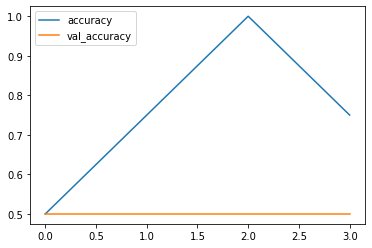

In [ ]:

history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [ ]:

Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

1/1 [==============================] - 0s 358ms/step


In [ ]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[0, 1],
       [0, 1]])

In [ ]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

ValueError: ignored